In [12]:
import select_sensor
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import traceback
import pandas as pd
from select_sensor import SelectSensor
import seaborn as sns

In [2]:
mean = [0, 0]
cov = [[0.5, 0], [0, 0.5]]

In [ ]:
np.random.multivariate_normal(mean, cov, 500)

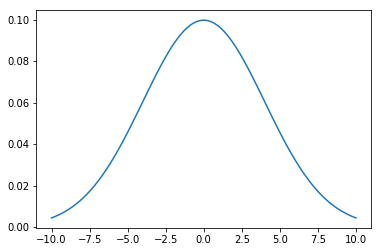

In [147]:
x = np.linspace(-10, 10, 100)
y = multivariate_normal.pdf(x, mean=0, cov=16); y

plt.plot(x, y)
plt.show()

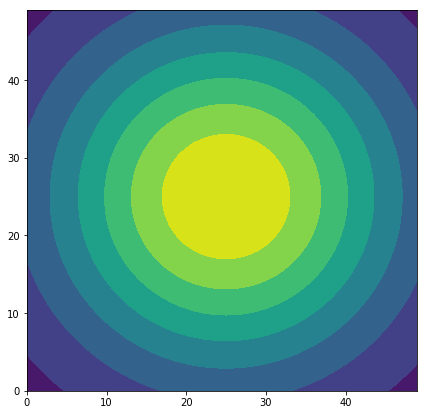

In [109]:
x, y = np.mgrid[0:50:1, 0:50:1]
pos = np.zeros(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal([25, 25], [[250, 0], [0, 250]])
plt.figure(figsize=(7,7))
plt.contourf(x, y, rv.pdf(pos))
plt.show()

In [155]:
np.random.normal(0, 1, 100)

array([-0.83071171,  0.81858282,  0.96619903,  0.30381744,  1.76480196,
        0.78173124,  0.02039526, -0.21954984, -0.45863556, -0.78998909,
        0.01913051, -0.36163942, -1.80709356, -0.08485889, -0.90631153,
        1.29751806, -0.83552573, -0.82401814, -0.65696238,  1.07338836,
        0.11348958, -0.57760581,  1.42974543,  0.55435839, -0.80260645,
       -0.27916257,  0.01482235,  0.84477149,  0.48283144, -0.57736637,
       -1.35412952, -1.19070578, -0.63398213,  0.60096092,  0.55116479,
       -0.59111888, -1.43813662,  0.08809413, -0.42199255, -0.49319979,
       -0.27059519, -1.27596253,  0.55350404, -0.74846936,  2.15117369,
       -0.83069957,  0.47683282, -0.37847878,  1.64818082, -0.23239726,
       -1.36948318, -1.36548314,  0.70444159,  0.26386536,  0.29904111,
        0.59820782, -0.08030546, -1.44037252,  0.42031234,  1.06575759,
       -0.15243188,  2.12559016,  0.12057482,  1.30672003, -1.03971165,
        0.66598499, -1.94159979, -1.27661481, -0.21935895, -1.30

In [84]:
x = np.array([[0, 2], [1, 1], [2, 0]])
x.shape

(3, 2)

In [113]:
x_pd = pd.DataFrame([[0, 2], [1, 1], [2, 0]])
x_pd

,0,1
0,0,2
1,1,1
2,2,0


In [89]:
x

array([[0, 2],
       [1, 1],
       [2, 0]])

In [103]:
x_pd.as_matrix()

array([[0, 2],
       [1, 1],
       [2, 0]])

In [148]:
x_pd.to_csv('./testing.csv', index=False, header=False)

In [151]:
np.cov(x_pd.as_matrix().T)

array([[ 1., -1.],
       [-1.,  1.]])

In [80]:
x = np.array([[0, 2], [1, 1], [2, 0]]).T
np.cov(x)

array([[ 1., -1.],
       [-1.,  1.]])

In [83]:
x_pd.shape

(3, 2)

In [98]:
np.zeros(0)

array([], dtype=float64)

In [112]:
round(555.233333333, 3)

555.233

In [18]:
data = pd.read_csv('./artificial_samples.csv', header=None)
sns.set(style="white")

corr = data.corr()
corr

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.000000,-0.001051,-0.001032,-0.001096,-0.001232,-0.001143,-0.000834,-0.000794,0.001968,-0.001143,...,0.001432,-0.001118,-0.001182,-0.000776,-0.001199,-0.000861,-0.000294,-0.001177,-0.001115,-0.001094
1,-0.001051,1.000000,0.000055,0.004823,-0.000914,0.002226,-0.000120,-0.000959,-0.001085,-0.001128,...,-0.001124,-0.001154,-0.001027,-0.001207,-0.000503,0.000096,-0.000786,-0.000922,-0.000959,-0.000812
2,-0.001032,0.000055,1.000000,0.000305,-0.000456,0.000602,-0.000135,-0.000251,-0.001123,-0.001115,...,-0.001109,-0.001182,-0.001026,-0.001099,-0.000805,-0.000540,-0.000417,-0.000595,-0.000414,0.000082
3,-0.001096,0.004823,0.000305,1.000000,-0.000811,0.006440,-0.000266,-0.000976,-0.001147,-0.001144,...,-0.001185,-0.001183,-0.000994,-0.001285,-0.000391,-0.000167,-0.000853,-0.000871,-0.000863,-0.000705
4,-0.001232,-0.000914,-0.000456,-0.000811,1.000000,-0.000725,-0.001169,-0.000216,-0.001169,0.000255,...,-0.001205,-0.000153,0.000311,-0.000572,-0.000526,-0.001094,-0.001125,0.019295,0.006195,0.002870
5,-0.001143,0.002226,0.000602,0.006440,-0.000725,1.000000,-0.000453,-0.000951,-0.001193,-0.001092,...,-0.001257,-0.001205,-0.000991,-0.001243,-0.000293,-0.000381,-0.000892,-0.000759,-0.000766,-0.000525
6,-0.000834,-0.000120,-0.000135,-0.000266,-0.001169,-0.000453,1.000000,-0.000894,-0.000972,-0.001304,...,-0.000977,-0.001322,-0.001258,-0.001251,-0.001053,0.000906,0.000222,-0.001177,-0.001140,-0.000987
7,-0.000794,-0.000959,-0.000251,-0.000976,-0.000216,-0.000951,-0.000894,1.000000,-0.000727,-0.000807,...,-0.000683,-0.000804,-0.000888,0.000191,-0.001138,-0.001033,-0.000467,-0.000297,0.000249,0.000547
8,0.001968,-0.001085,-0.001123,-0.001147,-0.001169,-0.001193,-0.000972,-0.000727,1.000000,-0.001085,...,0.008492,-0.001094,-0.001111,-0.000591,-0.001203,-0.000898,-0.000577,-0.001138,-0.001105,-0.001064
9,-0.001143,-0.001128,-0.001115,-0.001144,0.000255,-0.001092,-0.001304,-0.000807,-0.001085,1.000000,...,-0.001153,0.004241,0.002170,-0.000501,-0.000765,-0.001188,-0.001287,0.000387,0.000088,-0.000374


In [4]:
select_sensor = SelectSensor('config.json')
select_sensor.read_init_sensor()
select_sensor.compute_posterior()

Computed mean vector!
Computed covariance!


In [7]:
select_sensor.covariance

array([[  3.59929573e+05,  -3.78195530e+02,  -3.71364692e+02, ...,
         -4.23500569e+02,  -4.01390183e+02,  -3.93782215e+02],
       [ -3.78195530e+02,   3.59895656e+05,   1.96196507e+01, ...,
         -3.31911498e+02,  -3.44930832e+02,  -2.92346909e+02],
       [ -3.71364692e+02,   1.96196507e+01,   3.59836234e+05, ...,
         -2.14105215e+02,  -1.49120169e+02,   2.95330097e+01],
       ..., 
       [ -4.23500569e+02,  -3.31911498e+02,  -2.14105215e+02, ...,
          3.59839813e+05,   1.65066372e+03,   7.75489455e+02],
       [ -4.01390183e+02,  -3.44930832e+02,  -1.49120169e+02, ...,
          1.65066372e+03,   3.59817609e+05,   1.63935205e+03],
       [ -3.93782215e+02,  -2.92346909e+02,   2.95330097e+01, ...,
          7.75489455e+02,   1.63935205e+03,   3.59792043e+05]])

In [20]:
np.full((50, 50), 1/2500)

array([[ 0.0004,  0.0004,  0.0004, ...,  0.0004,  0.0004,  0.0004],
       [ 0.0004,  0.0004,  0.0004, ...,  0.0004,  0.0004,  0.0004],
       [ 0.0004,  0.0004,  0.0004, ...,  0.0004,  0.0004,  0.0004],
       ..., 
       [ 0.0004,  0.0004,  0.0004, ...,  0.0004,  0.0004,  0.0004],
       [ 0.0004,  0.0004,  0.0004, ...,  0.0004,  0.0004,  0.0004],
       [ 0.0004,  0.0004,  0.0004, ...,  0.0004,  0.0004,  0.0004]])